In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import seaborn as sns

print("Pandas version: {}".format(pd.__version__))
print("NumPy version: {}".format(np.__version__))

Pandas version: 2.2.3
NumPy version: 2.1.1


In [3]:
result_dir = "../case-study/datacenter"
fig_dir = "./figures"

In [5]:
df_summary = pd.read_csv(f"{result_dir}/summary_metrics.csv")
df_summary

,DateTime,Extractor,Folder,Interface,Throughput,Runtime (s),Avg_CPU_Usage (%),Avg_Memory_Usage (MB),Max_Memory_Usage (MB),CPU Cores,CPU Logical Cores,Total Memory (MB),Available Memory (MB)
0,2025-02-05 09:11:15,rustiflow,/data/rustiflow,eno3,NaN,89258.781116,64.494639,156.725145,175.039062,16,32,128868.382812,124797.277344


In [60]:
df_resources = pd.read_csv(f"{result_dir}/rustiflow_realtime_metrics.csv")
df_resources_24h = df_resources.iloc[:86400]
df_resources_24h

,Interval,CPU_Usage (%),Memory_Usage (MB),CPU_Num,Num_Threads,Open_Files,Context_Switches,Child Processes
0,1,0.0,5.421875,[0],1,0,3,0
1,2,0.0,90.777344,"[0, 31]",34,0,43,1
2,3,51.5,91.339844,"[0, 31]",34,0,43,1
3,4,39.6,91.339844,"[0, 31]",34,0,43,1
4,5,37.6,91.593750,"[0, 31]",34,0,43,1
...,...,...,...,...,...,...,...,...
86395,86396,72.2,175.039062,"[0, 31]",34,0,43,1
86396,86397,75.1,175.039062,"[0, 31]",34,0,43,1
86397,86398,36.6,175.039062,"[0, 31]",34,0,43,1
86398,86399,11.9,175.039062,"[0, 31]",34,0,43,1


In [70]:
df_resources_5s = (
    df_resources[["CPU_Usage (%)", "Memory_Usage (MB)"]]
    .groupby(df_resources.index.astype(int) // 5)
    .mean()
)
df_resources_5s

,CPU_Usage (%),Memory_Usage (MB)
0,25.74,74.094531
1,93.86,92.682812
2,51.28,94.330469
3,53.42,95.019531
4,43.90,96.538281
...,...,...
17643,18.00,175.039062
17644,14.62,175.039062
17645,22.56,175.039062
17646,17.60,175.039062


In [50]:
df_network = pd.read_csv(f"{result_dir}/ifstat.log", delim_whitespace=True, skiprows=1)
df_network.columns = ["time", "rx", "tx"]
df_network_24h = df_network.iloc[:17280]
df_network_24h

/tmp/ipykernel_185134/3457578461.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_network = pd.read_csv(f"{result_dir}/ifstat.log", delim_whitespace=True, skiprows=1)


,time,rx,tx
0,09:11:20,12669.17,0.0
1,09:11:25,28143.37,0.0
2,09:11:30,15534.90,0.0
3,09:11:35,20500.37,0.0
4,09:11:40,18430.54,0.0
...,...,...,...
17275,09:12:24,190380.40,0.0
17276,09:12:29,174139.80,0.0
17277,09:12:34,179867.30,0.0
17278,09:12:39,154523.50,0.0


# Plot CPU and Memory in function of time

In [142]:
max_value = df_network["rx"].rolling(window=60).mean().max()
max_index = df_network["rx"].rolling(window=60).mean().idxmax()
max_index, max_value

(11368, np.float64(177166.34833333333))

In [161]:
max_cpu_value = df_resources_5s["CPU_Usage (%)"].rolling(window=12 * 5).mean().max()
max_cpu_index = df_resources_5s["CPU_Usage (%)"].rolling(window=12 * 5).mean().idxmax()
max_cpu_index, max_cpu_value

(np.int64(11247), np.float64(135.73366666666666))

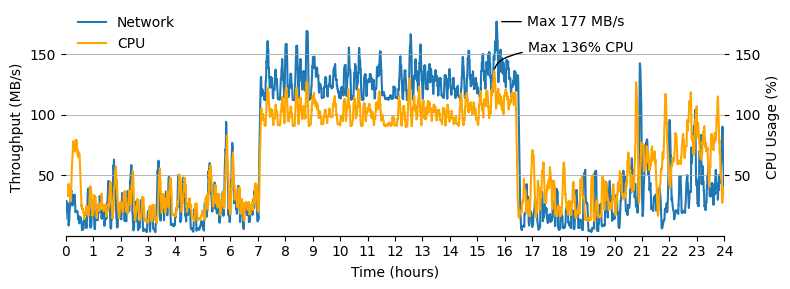

In [212]:
fig, ax1 = plt.subplots(figsize=(8, 3))
ax1.plot(
    df_network.index - 60,  # 5min offset to compensate for slower start of rustiflow
    df_network["rx"].rolling(window=5*12).mean(),
    label="Network",
)
ax1.annotate(
    "Max {:.0f} MB/s".format(max_value / 1000),
    (max_index, max_value),
    textcoords="offset points",
    xytext=(20, 0),
    ha="left",
    va="center",
    arrowprops=dict(arrowstyle="-"), #, color='C0'),
    size="medium",
    # color='C0'
)

ax1.set_xticks(range(0, len(df_network["time"]) + 1, 12 * 60))  # 1 hour
ax1.set_xticklabels(
    [(i * 5) // 3600 for i in range(0, len(df_network["time"]) + 1, 12 * 60)]
)
ax1.set_xlim(0, 17280)  # each point is 5 seconds -> 24 hours = 17280 points
ax1.set_xlabel("Time (hours)")
ax1.set_ylim(0, 180000)
ax1.set_ylabel("Throughput (MB/s)")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.set_yticks([50_000, 100_000, 150_000])

ax2 = ax1.twinx()

df_resources_5s["CPU_Usage (%)"].rolling(window=12 * 5).mean().plot(color="orange", ax=ax2, label="CPU")
ax2.annotate(
    "Max {:.0f}% CPU".format(max_cpu_value),
    (max_cpu_index, max_cpu_value),
    textcoords="offset points",
    xytext=(24, 17),
    ha="left",
    va="center",
    arrowprops=dict(arrowstyle="-", connectionstyle="angle3,angleA=0,angleB=90"), #, color='C1'),
    size="medium",
    # color='C1'
)

ax2.set_xlim(0, 17280)  # each point is 5 seconds -> 24 hours = 17280 points
ax2.set_ylim(0, 180)
ax2.set_ylabel("CPU Usage (%)")
ax2.set_yticks([50, 100, 150])

# Collect handles and labels for the legend
handles, labels = [], []
for ax in [ax1, ax2]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

for ax in [ax1, ax2]:
    ax.yaxis.grid(True, linewidth=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)

ax1.legend(handles, labels, loc="upper left", frameon=False, bbox_to_anchor=(0.0, 1.07))

plt.tight_layout()
plt.savefig(f'{fig_dir}/datacenter_24h_cpu_throughput.pdf', bbox_inches='tight')
plt.show()